In [39]:
from pathlib import Path
import json
import pandas as pd
import difflib

def _read_json_as_rows(json_path: Path) -> pd.DataFrame:
    """
    Reads a JSON file and returns a flattened DataFrame.
    - If top-level is a list -> rows = list
    - If top-level is a dict with a single list value -> rows = that list
    - Else -> single-row DataFrame from the dict
    """
    text = json_path.read_text(encoding="utf-8")
    obj = json.loads(text)

    if isinstance(obj, list):
        rows = obj
    elif isinstance(obj, dict):
        list_keys = [k for k, v in obj.items() if isinstance(v, list)]
        if len(list_keys) == 1:
            rows = obj[list_keys[0]]
        else:
            rows = [obj]
    else:
        raise ValueError(f"Unsupported JSON structure in {json_path}")

    return pd.json_normalize(rows, sep=".")

def _find_md(md_dir: Path, base: str) -> Path | None:
    """
    Finds a matching .md file for a given base name.
    Tries exact match first; then a fuzzy match among all .md stems.
    """
    exact = md_dir / f"{base}.md"
    if exact.exists():
        return exact

    # fuzzy fallback
    stems = {p.stem: p for p in md_dir.glob("*.md")}
    matches = difflib.get_close_matches(base, stems.keys(), n=1, cutoff=0.9)
    return stems[matches[0]] if matches else None

def load_and_map(
    reports_json_dir: str = "reports_json",
    reports_md_dir: str = "reports_md",
    include_md_text: bool = True,
) -> pd.DataFrame:
    """
    Walks both folders, mapping JSON files to Markdown by base filename.
    Returns a single combined DataFrame with:
      - report_id (base filename)
      - json_path, md_path
      - markdown (optional full text)
      - flattened JSON fields (columns)
    """
    json_dir = Path(reports_json_dir)
    md_dir = Path(reports_md_dir)

    all_parts: list[pd.DataFrame] = []

    for jp in sorted(json_dir.glob("*.json")):
        base = jp.stem
        df = _read_json_as_rows(jp)

        mdp = _find_md(md_dir, base)
        md_text = mdp.read_text(encoding="utf-8") if (include_md_text and mdp and mdp.exists()) else None

        # annotate
        df.insert(0, "report_id", base)
        df["json_path"] = str(jp)
        df["md_path"] = str(mdp) if mdp else None
        if include_md_text:
            df["markdown"] = md_text

        all_parts.append(df)

    if not all_parts:
        # empty but with the key columns
        cols = ["report_id", "json_path", "md_path"] + (["markdown"] if include_md_text else [])
        return pd.DataFrame(columns=cols)

    combined = pd.concat(all_parts, ignore_index=True)
    return combined


def clean_report_id(s: str) -> str:
    s = str(s).strip()
    m = re.match(r'(?i)^report\((.*)\)$', s)   # case-insensitive "report(...)"
    if m:
        return m.group(1).strip()
    # fallback: strip a leading "report", with optional separators
    s = re.sub(r'(?i)^report[\s_\-]*', '', s)
    return s.strip(' "')

if __name__ == "__main__":
    df = load_and_map("reports_json", "reports_md", include_md_text=True)
    df = df.copy()
    df["report_id"] = df["report_id"].apply(clean_report_id)    
    print(df.shape)
    print(df.head(3))

    # Optional: save
    # df.to_csv("reports_combined.csv", index=False)
    # df.to_parquet("reports_combined.parquet", index=False)

(7, 56)
       report_id global_notes  criteria.A1.band  \
0          GPT-5                              3   
1  autoclassmate                              3   
2         edcafe                              3   

                                criteria.A1.evidence criteria.A1.notes  \
0  The lesson plan includes SMARTIE outcomes (def...                     
1  The learning objective is clearly stated: 'By ...                     
2  The lesson plan includes SMARTIE outcomes (e.g...                     

   criteria.A2.band                               criteria.A2.evidence  \
0                 3  The lesson plan includes alignment between lea...   
1                 3  The lesson plan includes a mix of activities t...   
2                 3  The lesson plan aligns the NY College and Care...   

  criteria.A2.notes  criteria.A3.band  \
0                                   2   
1                                   2   
2                                   2   

                            

In [40]:
# 1) All columns as a Python list (quick glance)
print(df.columns.tolist())

['report_id', 'global_notes', 'criteria.A1.band', 'criteria.A1.evidence', 'criteria.A1.notes', 'criteria.A2.band', 'criteria.A2.evidence', 'criteria.A2.notes', 'criteria.A3.band', 'criteria.A3.evidence', 'criteria.A3.notes', 'criteria.B1.band', 'criteria.B1.evidence', 'criteria.B1.notes', 'criteria.B2.band', 'criteria.B2.evidence', 'criteria.B2.notes', 'criteria.B3.band', 'criteria.B3.evidence', 'criteria.B3.notes', 'criteria.C1.band', 'criteria.C1.evidence', 'criteria.C1.notes', 'criteria.C2.band', 'criteria.C2.evidence', 'criteria.C2.notes', 'criteria.C3.band', 'criteria.C3.evidence', 'criteria.C3.notes', 'criteria.D1.band', 'criteria.D1.evidence', 'criteria.D1.notes', 'criteria.D2.band', 'criteria.D2.evidence', 'criteria.D2.notes', 'criteria.D3.band', 'criteria.D3.evidence', 'criteria.D3.notes', 'criteria.E1.band', 'criteria.E1.evidence', 'criteria.E1.notes', 'criteria.E2.band', 'criteria.E2.evidence', 'criteria.E2.notes', 'criteria.E3.band', 'criteria.E3.evidence', 'criteria.E3.not

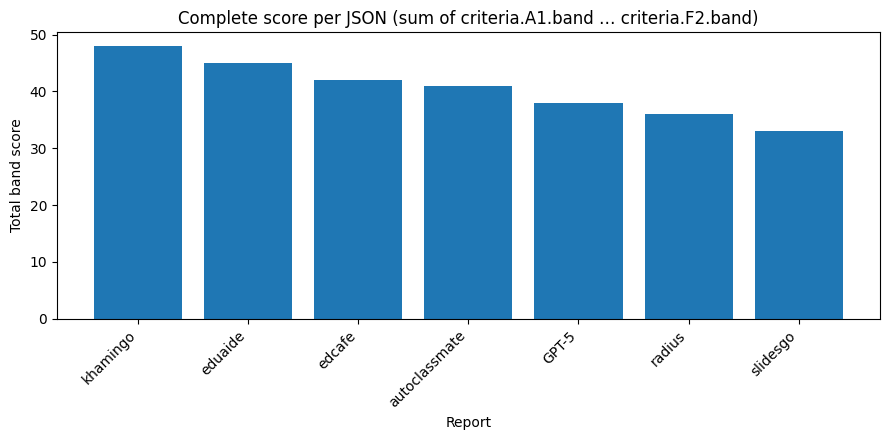

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Pick exactly the band columns A1–E3, F1–F2 ---
expected_band_cols = (
    [f"criteria.{sec}{i}.band" for sec in "ABCDE" for i in (1, 2, 3)]
    + [f"criteria.F{i}.band" for i in (1, 2)]
)
band_cols = [c for c in expected_band_cols if c in df.columns]

# --- 2) Make sure they're numeric ---
df[band_cols] = df[band_cols].apply(pd.to_numeric, errors="coerce")

# --- 3) One row per report_id with a single value per band column ---
# If your df has multiple rows per report_id, this takes the first non-null value
# in each band column for that report (avoids double-counting duplicates).
dedup = (
    df.groupby("report_id", as_index=False)[band_cols]
      .agg(lambda s: s.dropna().iloc[0] if not s.dropna().empty else pd.NA)
)

# --- 4) Total score = sum across A1–F2 bands ---
# Use .sum(min_count=1) so a report with all-NaN stays NaN (change to fillna(0) if you prefer).
dedup["total_score"] = dedup[band_cols].sum(axis=1, min_count=1)

# Optional: sort for a nicer plot
dedup = dedup.sort_values("total_score", ascending=False, na_position="last")

# --- 5) Plot ---
plt.figure(figsize=(9, 4.5))
plt.bar(dedup["report_id"], dedup["total_score"])
plt.title("Complete score per JSON (sum of criteria.A1.band … criteria.F2.band)")
plt.xlabel("Report")
plt.ylabel("Total band score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 6) (Optional) Save results ---
# dedup[["report_id", "total_score"]].to_csv("complete_scores.csv", index=False)
# plt.savefig("complete_scores.png", dpi=150)

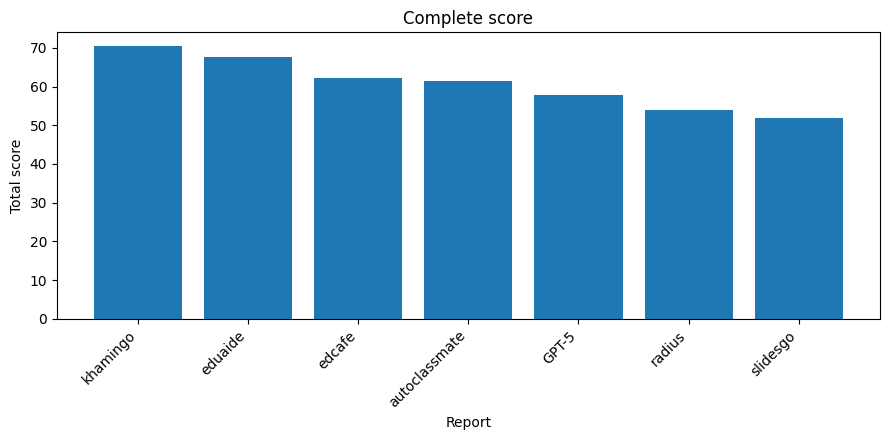

In [42]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) Regex to capture: **A1 ...** — band 3 → 6.0/8
#    Handles different dashes/arrows and spaces.
# ----------------------------------------
MD_SCORE_RE = re.compile(
    r"""
    \*\*\s*(?P<code>[A-F][1-3])\b.*?\*\*      # **A1 ...**
    .*?
    (?:—|–|-) \s* band \s* (?P<band>\d+)      # — band 3
    \s* (?:→|->|—|:)\s*
    (?P<score>\d+(?:\.\d+)?) \s*/\s* (?P<denom>\d+)   # 6.0/8
    """,
    re.IGNORECASE | re.VERBOSE | re.DOTALL,
)

# ----------------------------------------
# 2) Helper: parse one markdown string into { 'A1': (score, denom), ... }
# ----------------------------------------
def parse_md_scores(md_text: str) -> dict:
    found = {}
    if not isinstance(md_text, str) or not md_text.strip():
        return found
    for m in MD_SCORE_RE.finditer(md_text):
        code = m.group("code").upper()    # e.g., 'A1'
        score = float(m.group("score"))
        denom = int(m.group("denom"))
        # keep first occurrence per code
        if code not in found:
            found[code] = (score, denom)
    return found

# ----------------------------------------
# 3) Extract one markdown per report_id, parse it, widen to columns
#    Assumes your combined dataframe is named `df`
#    and includes columns: 'report_id' and 'markdown'
#    If `markdown` is missing, swap to 'md_path' and read files there.
# ----------------------------------------
if "markdown" not in df.columns:
    raise ValueError("Expected a 'markdown' column in df. Re-run your loader with include_md_text=True.")

md_by_report = (
    df[["report_id", "markdown"]]
    .dropna(subset=["markdown"])
    .drop_duplicates(subset=["report_id"], keep="first")
    .set_index("report_id")["markdown"]
)

rows = []
for rid, md_text in md_by_report.items():
    parsed = parse_md_scores(md_text)  # {'A1': (6.0, 8), ...}
    row = {"report_id": rid}
    for code, (score, denom) in parsed.items():
        row[f"criteria.{code}.md_score"] = score
        row[f"criteria.{code}.md_denom"] = denom  # kept for reference; not used in the sum
    rows.append(row)

df_md = pd.DataFrame(rows).fillna(pd.NA)

# ----------------------------------------
# 4) Merge back to your original df (one row per report for plotting)
#    If you already have multiple rows per report, deduplicate first.
# ----------------------------------------
# Keep one row per report_id from the original df (first occurrence)
df_one = df.drop_duplicates(subset=["report_id"], keep="first")

df_merged = df_one.merge(df_md, on="report_id", how="left")

# ----------------------------------------
# 5) Compute total MD score (sum of A1–E3, F1–F2 md_score columns)
# ----------------------------------------
expected_codes = [f"{sec}{i}" for sec in "ABCDE" for i in (1,2,3)] + [f"F{i}" for i in (1,2)]
md_cols = [f"criteria.{c}.md_score" for c in expected_codes if f"criteria.{c}.md_score" in df_merged.columns]

# If a score is missing, treat it as 0 (or keep as NaN: remove fillna(0) if you prefer).
df_merged["total_md_score"] = df_merged[md_cols].fillna(0).sum(axis=1)

# (Optional) Also compute percentage of maximum possible (8 points each criterion)
max_per_report = 8 * len(md_cols) if md_cols else pd.NA
if md_cols:
    df_merged["total_md_pct"] = (df_merged["total_md_score"] / (8 * len(md_cols))) * 100


# If you’ve already made af_totals, do it there instead (either one is fine):
# af_totals['report_id'] = normalize_report_id(af_totals['report_id'])

# ----------------------------------------
# 6) Plot
# ----------------------------------------
plot_df = df_merged.sort_values("total_md_score", ascending=False)
plt.figure(figsize=(9, 4.5))
plt.bar(plot_df["report_id"], plot_df["total_md_score"])
plt.title("Complete score")
plt.xlabel("Report")
plt.ylabel("Total score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ----------------------------------------
# 7) (Optional) Save results
# ----------------------------------------
# df_merged.to_csv("md_scores_merged.csv", index=False)
# plt.savefig("md_complete_scores.png", dpi=150)

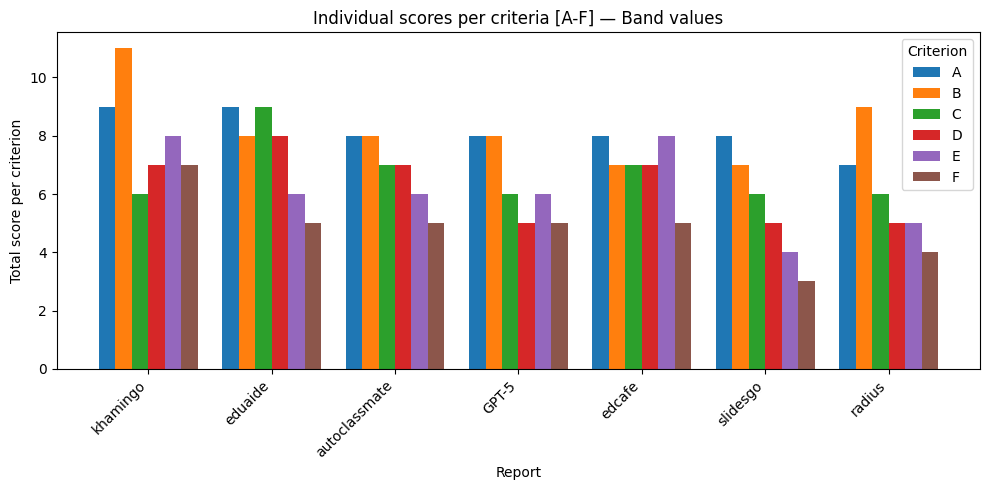

In [43]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Choose score source: 'md' uses criteria.XY.md_score; 'band' uses criteria.XY.band ---
PREFERRED_SOURCE = "md"   # change to "band" if you want band numbers

# --- 1) Figure out which columns exist ---
def columns_for(letter: str, source: str, cols: list[str]) -> list[str]:
    if letter in "ABCDE":
        codes = [f"{letter}{i}" for i in (1,2,3)]
    else:  # F
        codes = [f"{letter}{i}" for i in (1,2)]
    suffix = ".md_score" if source == "md" else ".band"
    return [f"criteria.{c}{suffix}" for c in codes if f"criteria.{c}{suffix}" in cols]

have_md = any(c.endswith(".md_score") for c in df.columns)
score_source = "md" if (PREFERRED_SOURCE == "md" and have_md) else "band"

letters = list("ABCDEF")
band_cols_by_letter = {L: columns_for(L, score_source, df.columns.tolist()) for L in letters}
# remove letters with no data at all
band_cols_by_letter = {L: cols for L, cols in band_cols_by_letter.items() if cols}

# --- 2) Ensure numeric and reduce to one row per report_id ---
all_cols = sorted(set(sum(band_cols_by_letter.values(), [])))
df[all_cols] = df[all_cols].apply(pd.to_numeric, errors="coerce")

# If your df has multiple rows per report_id, keep the first non-null per column (avoids double counting)
df_one = (
    df[["report_id"] + all_cols]
    .groupby("report_id", as_index=False)
    .agg(lambda s: s.dropna().iloc[0] if not s.dropna().empty else np.nan)
)

# --- 3) Sum to A–F totals per report ---
for L, cols in band_cols_by_letter.items():
    df_one[f"{L}_total"] = df_one[cols].sum(axis=1, min_count=1)  # remove fillna(0) to keep NaN if all missing

tot_cols = [f"{L}_total" for L in band_cols_by_letter.keys()]
af_totals = df_one[["report_id"] + tot_cols].copy()

# (Optional) Percent-of-maximum per letter (8 points per subcriterion)
denoms = {L: (3 if L in "ABCDE" else 2) * 8 for L in band_cols_by_letter.keys()}
for L in band_cols_by_letter.keys():
    af_totals[f"{L}_pct"] = (af_totals[f"{L}_total"] / denoms[L]) * 100

# --- 4) Plot grouped bars (raw totals) ---
plot_df = af_totals.sort_values(tot_cols, ascending=[False]*len(tot_cols))
reports = plot_df["report_id"].tolist()
x = np.arange(len(reports))
k = len(tot_cols)
width = 0.8 / max(k,1)

plt.figure(figsize=(10, 5))
for i, L in enumerate(band_cols_by_letter.keys()):
    plt.bar(x + (i - (k-1)/2) * width, plot_df[f"{L}_total"], width=width, label=L)

title_src = "Markdown scores (x/8)" if score_source == "md" else "Band values"
plt.title(f"Individual scores per criteria [A-F] — {title_src}")
plt.xlabel("Report")
plt.ylabel("Total score per criterion")
plt.xticks(x, reports, rotation=45, ha="right")
plt.legend(title="Criterion")
plt.tight_layout()
plt.show()

# --- 5) (Optional) Plot as percentages instead of raw totals ---
# plt.figure(figsize=(10, 5))
# for i, L in enumerate(band_cols_by_letter.keys()):
#     plt.bar(x + (i - (k-1)/2) * width, plot_df[f"{L}_pct"], width=width, label=L)
# plt.title(f"A–F criteria (%) per report — {title_src}")
# plt.xlabel("Report")
# plt.ylabel("Percent of max per criterion")
# plt.xticks(x, reports, rotation=45, ha="right")
# plt.legend(title="Criterion")
# plt.tight_layout()
# plt.show()

In [44]:
import re
from pathlib import Path
import pandas as pd

# ---------- 0) Grab ONE markdown source ----------
def get_one_markdown(df: pd.DataFrame) -> str:
    if "markdown" in df.columns and df["markdown"].notna().any():
        return df.loc[df["markdown"].notna(), "markdown"].iloc[0]
    if "md_path" in df.columns and df["md_path"].notna().any():
        mdp = df.loc[df["md_path"].notna(), "md_path"].iloc[0]
        return Path(mdp).read_text(encoding="utf-8")
    raise ValueError("Need a 'markdown' column (or 'md_path') in df.")

md_text = get_one_markdown(df)

# ---------- 1) Regexes ----------
# Lines like: **A1 SMARTIE Outcomes & Success Criteria** — band 3 → 6.0/8
SUB_RE = re.compile(
    r"\*\*\s*(?P<code>(?:[A-E][1-3]|F[1-2]))\s+(?P<title>.+?)\s*\*\*",
    re.IGNORECASE | re.DOTALL
)

# A few patterns for letter-level headings (A–F)
LETTER_PATTERNS = [
    re.compile(r"^\s{0,3}#{1,6}\s*(?:Criterion\s*)?(?P<letter>[A-F])(?!\d)[\.\)]?\s*[:\-–—]\s*(?P<title>.+)$",
               re.IGNORECASE | re.MULTILINE),
    re.compile(r"^\s{0,3}#{1,6}\s*(?P<letter>[A-F])(?!\d)[\.\)]?\s*(?P<title>.+)$",
               re.IGNORECASE | re.MULTILINE),
    re.compile(r"\*\*\s*(?:Criterion\s*)?(?P<letter>[A-F])(?!\d)[\.\)]?\s*[:\-–—]\s*(?P<title>.+?)\s*\*\*",
               re.IGNORECASE | re.DOTALL),
    re.compile(r"(?mi)^\s*Criterion\s+(?P<letter>[A-F])\s*[:\-–—]\s*(?P<title>.+)\s*$",
               re.IGNORECASE),
]

def parse_letter_descriptions(text: str) -> dict[str, str]:
    out = {}
    for pat in LETTER_PATTERNS:
        for m in pat.finditer(text):
            L = m.group("letter").upper()
            out.setdefault(L, m.group("title").strip())
    return out

def parse_sub_descriptions(text: str) -> dict[str, str]:
    out = {}
    for m in SUB_RE.finditer(text):
        code = m.group("code").upper()
        title = m.group("title").strip()
        out.setdefault(code, title)
    return out

letter_desc = parse_letter_descriptions(md_text)
sub_desc = parse_sub_descriptions(md_text)

# ---------- 2) Build a single, tidy DF (common for all reports) ----------
rows = []
for L in list("ABCDE") + ["F"]:
    codes = [f"{L}{i}" for i in (1, 2, 3)] if L != "F" else [f"{L}{i}" for i in (1, 2)]
    for code in codes:
        rows.append({
            "criterion": L,
            "criterion_desc": letter_desc.get(L),
            "subcriterion": code,
            "subcriterion_desc": sub_desc.get(code)
        })

criteria_desc_df = pd.DataFrame(rows)

# ---------- 3) Print once, nicely ----------
print("=== Common Criteria Descriptions ===")
for L, g in criteria_desc_df.groupby("criterion", sort=True):
    cdesc = g["criterion_desc"].dropna().iloc[0] if g["criterion_desc"].notna().any() else "(no criterion description found)"
    print(f"{L}: {cdesc}")
    for _, r in g.iterrows():
        sc = r["subcriterion"]
        sdesc = r["subcriterion_desc"] if pd.notna(r["subcriterion_desc"]) else "(no sub-criterion title found)"
        print(f"  {sc}: {sdesc}")

# (Optional) Save the tidy table
# criteria_desc_df.to_csv("criteria_descriptions_common.csv", index=False)

=== Common Criteria Descriptions ===
A: Outcomes & Alignment — 17 pts
  A1: SMARTIE Outcomes & Success Criteria
  A2: Alignment: TLAs ↔ Outcomes ↔ Assessment
  A3: Structure, Timing & Flow
B: Engagement & Interaction — 13 pts
  B1: ICAP Engagement Mix
  B2: Generative Tasks & Prompts
  B3: Whole-class Participation & Interactivity
C: Retrieval & Assessment for Learning — 10 pts
  C1: Retrieval Density & Effort
  C2: Formative Checks & Actionable Feedback
  C3: Spacing, Delayed Checks & Cumulative Coverage
D: Instructional Design & Scaffolding — 6 pts
  D1: Models/Worked Examples & Guided Practice
  D2: Scaffolds & Fading (Generative)
  D3: Independent Practice & Monitoring
E: Cognitive Load & Adaptation — 6 pts
  E1: Intrinsic Load Sequencing
  E2: Extraneous Load Minimization & Modality
  E3: Expertise Adaptation & Load Monitoring
F: Inclusivity, Culture & Reflection — 5 pts
  F1: UDL & Accessibility
  F2: Culture of Success & Reflection


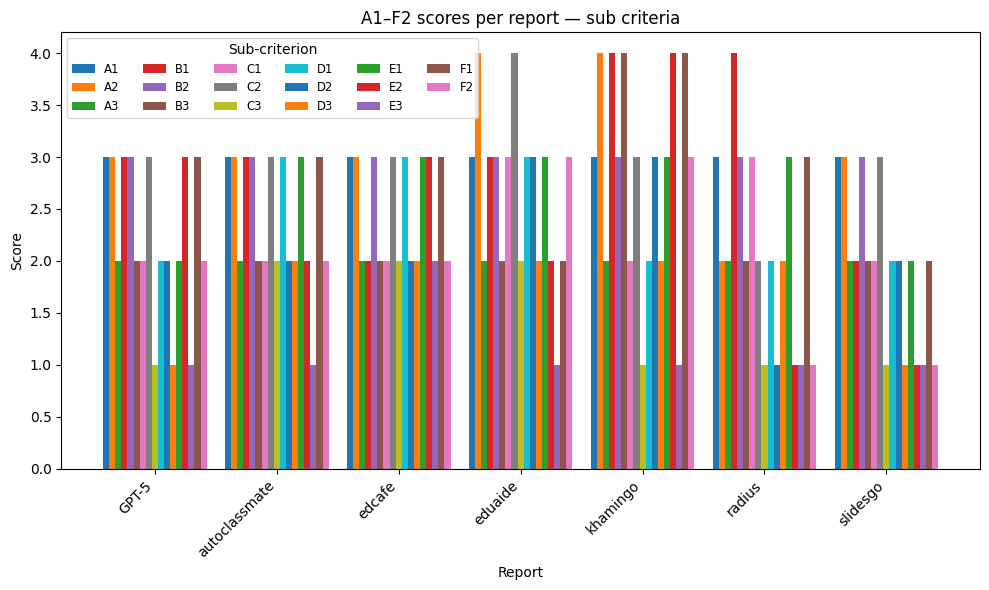

In [54]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Clean report names like "report(khamingo)" -> "khamingo" ---
def clean_report_id(s: str) -> str:
    s = str(s).strip()
    m = re.match(r'(?i)^report\((.*)\)$', s)
    if m:
        return m.group(1).strip()
    s = re.sub(r'(?i)^report[\s_\-]*', '', s)
    return s.strip(' "')

df = df.copy()
if "report_id" not in df.columns:
    raise ValueError("Expected a 'report_id' column in df.")
df["report_id"] = df["report_id"].apply(clean_report_id)

# --- 1) Choose source: prefer Markdown "x/8" scores, else bands ---
have_md = any(c.endswith(".md_score") for c in df.columns)
suffix = ".md_score" if have_md else ".band"

# --- 2) Build the sub-criterion list and pick columns that actually exist ---
subcodes = [f"{L}{i}" for L in "ABCDE" for i in (1,2,3)] + [f"F{i}" for i in (1,2)]
subcols = [f"criteria.{code}{suffix}" for code in subcodes if f"criteria.{code}{suffix}" in df.columns]
if not subcols:
    raise ValueError("No A1–F2 score columns found (neither *.md_score nor *.band).")

# --- 3) Ensure numeric and reduce to one row per report (first non-null per column) ---
df[subcols] = df[subcols].apply(pd.to_numeric, errors="coerce")
df_one = (
    df[["report_id"] + subcols]
    .groupby("report_id", as_index=False)
    .agg(lambda s: s.dropna().iloc[0] if not s.dropna().empty else np.nan)
)

# Optional: order reports (alphabetical); change to your preferred sort
df_one = df_one.sort_values("report_id")

# --- 4) Plot grouped bars: one bar per sub-criterion (A1..E3, F1..F2) for each report ---
reports = df_one["report_id"].tolist()
x = np.arange(len(reports))
k = len(subcols)
width = 0.85 / max(k, 1)

plt.figure(figsize=(max(10, len(reports)*1.3), 6))
for i, col in enumerate(subcols):
    code = col.split(".")[1]  # e.g., "A1"
    y = df_one[col].fillna(0).to_numpy()
    plt.bar(x + (i - (k-1)/2) * width, y, width=width, label=code)

title_src = "Markdown scores (x/8)" if have_md else "sub criteria"
plt.title(f"A1–F2 scores per report — {title_src}")
plt.xlabel("Report")
plt.ylabel("Score")
plt.xticks(x, reports, rotation=45, ha="right")
# Many legend entries: wrap into multiple columns for readability
plt.legend(title="Sub-criterion", ncol=6, fontsize="small")
plt.tight_layout()
plt.show()

In [46]:
import re
from pathlib import Path
import pandas as pd

# --- 1) Get one markdown source from your df ---
def get_one_markdown(df: pd.DataFrame) -> str:
    if "markdown" in df.columns and df["markdown"].notna().any():
        return df.loc[df["markdown"].notna(), "markdown"].iloc[0]
    if "md_path" in df.columns and df["md_path"].notna().any():
        mdp = df.loc[df["md_path"].notna(), "md_path"].iloc[0]
        return Path(mdp).read_text(encoding="utf-8")
    raise ValueError("Need a 'markdown' column (or 'md_path') in df.")

md_text = get_one_markdown(df)

# --- 2) Parse sub-criterion titles like:
# **A1 SMARTIE Outcomes & Success Criteria** — band 3 → 6.0/8
SUB_RE = re.compile(
    r"\*\*\s*(?P<code>(?:[A-E][1-3]|F[1-2]))\s+(?P<title>.+?)\s*\*\*",
    re.IGNORECASE | re.DOTALL
)

def parse_sub_descriptions(text: str) -> dict:
    out = {}
    for m in SUB_RE.finditer(text):
        code = m.group("code").upper()
        title = re.sub(r"\s+", " ", m.group("title")).strip()
        out.setdefault(code, title)  # keep first occurrence
    return out

subs = parse_sub_descriptions(md_text)

# --- 3) Print A1–F2 descriptions (once) ---
order = [f"{L}{i}" for L in "ABCDE" for i in (1,2,3)] + [f"F{i}" for i in (1,2)]
print("=== A1–F2 Criteria Descriptions ===")
for code in order:
    print(f"{code}: {subs.get(code, '(no title found)')}")

# Optional: tidy table if you want to reuse later
# criteria_desc_df = pd.DataFrame({"subcriterion": order,
#                                  "description": [subs.get(c) for c in order]})
# criteria_desc_df.to_csv("criteria_descriptions_one.csv", index=False)

=== A1–F2 Criteria Descriptions ===
A1: SMARTIE Outcomes & Success Criteria
A2: Alignment: TLAs ↔ Outcomes ↔ Assessment
A3: Structure, Timing & Flow
B1: ICAP Engagement Mix
B2: Generative Tasks & Prompts
B3: Whole-class Participation & Interactivity
C1: Retrieval Density & Effort
C2: Formative Checks & Actionable Feedback
C3: Spacing, Delayed Checks & Cumulative Coverage
D1: Models/Worked Examples & Guided Practice
D2: Scaffolds & Fading (Generative)
D3: Independent Practice & Monitoring
E1: Intrinsic Load Sequencing
E2: Extraneous Load Minimization & Modality
E3: Expertise Adaptation & Load Monitoring
F1: UDL & Accessibility
F2: Culture of Success & Reflection


In [47]:
import re
import numpy as np
import pandas as pd

# ---------- 1) Clean report names like "report(khamingo)" -> "khamingo" ----------
def clean_report_id(s: str) -> str:
    s = str(s).strip()
    m = re.match(r'(?i)^report\((.*)\)$', s)   # case-insensitive "report(...)"
    if m:
        return m.group(1).strip()
    s = re.sub(r'(?i)^report[\s_\-]*', '', s)
    return s.strip(' "')

if "report_id" not in df.columns:
    raise ValueError("Expected a 'report_id' column in df.")

df = df.copy()
df["report_id"] = df["report_id"].apply(clean_report_id)

# ---------- 2) Determine which evidence columns exist (A1–E3, F1–F2) ----------
subcodes = [f"{L}{i}" for L in "ABCDE" for i in (1,2,3)] + [f"F{i}" for i in (1,2)]
evidence_cols = [f"criteria.{code}.evidence" for code in subcodes if f"criteria.{code}.evidence" in df.columns]

if not evidence_cols:
    raise ValueError(
        "No evidence columns found. Expected columns like 'criteria.A1.evidence'. "
        "Make sure your JSON was flattened with sep='.'."
    )

# ---------- 3) Reduce to one row per report_id: pick the 'best' (longest) non-empty text per evidence column ----------
def pick_best_text(s: pd.Series) -> str | None:
    s = s.dropna().astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    s = s[s != ""]
    if s.empty:
        return None
    # choose the longest non-empty string (often the most complete evidence)
    idx = s.str.len().idxmax()
    return s.loc[idx]

df_one = (
    df[["report_id"] + evidence_cols]
    .groupby("report_id", as_index=False)
    .agg({col: pick_best_text for col in evidence_cols})
)

# ---------- 4) Build a tidy table: report, criterion letter, subcriterion, evidence ----------
rows = []
for _, row in df_one.iterrows():
    rid = row["report_id"]
    for code in subcodes:
        col = f"criteria.{code}.evidence"
        if col in df_one.columns:
            rows.append({
                "report": rid,
                "criterion": code[0],
                "subcriterion": code,
                "evidence": row[col]
            })

evidence_df = pd.DataFrame(rows)

# ---------- 5) Print nicely: for each report, list A1–F2 evidence ----------
for report, grp in evidence_df.groupby("report"):
    print(f"\n=== {report} ===")
    for L in list("ABCDE") + ["F"]:
        codes = [f"{L}{i}" for i in (1,2,3)] if L != "F" else [f"{L}{i}" for i in (1,2)]
        for code in codes:
            ev = grp.loc[grp["subcriterion"] == code, "evidence"]
            ev_text = ev.iloc[0] if not ev.empty and pd.notna(ev.iloc[0]) else "(no evidence provided)"
            print(f"{code}: {ev_text}")

# (Optional) Save the tidy table to reuse elsewhere:
# evidence_df.to_csv("all_reports_evidence_A1_F2.csv", index=False)


=== GPT-5 ===
A1: The lesson plan includes SMARTIE outcomes (define AI literacy, identify various use cases of AI across different industries, and critically analyze the implications of these use cases in real-world contexts) with clear criteria.
A2: The lesson plan includes alignment between learning objectives (define AI literacy, identify various use cases of AI across different industries, and critically analyze the implications of these use cases in real-world contexts) and assessment tasks (exit ticket + micro-quiz).
A3: The lesson plan includes a coherent sequence (hook, definitions & scope, group activity, short presentations, class discussion & debrief, wrap-up & assessment) but with minor issues in step design.
B1: The lesson plan includes a mix of interactive and constructive modes (group activity, short presentations, class discussion & debrief), aiming for ≥50% C+I with some I.
B2: The lesson plan includes generative tasks and prompts that require explain/justify/compare/